# Storing CNN Layer Activations
First we need to import some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms

import PIL
from PIL import Image

from os import listdir

# from sklearn.manifold import TSNE

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

We also need to load the image data.

In [2]:
imsize = 224
root = 'ilsvrc_parse/sel_images/'
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
loader = transforms.Compose([transforms.Scale((imsize, imsize)),
                             transforms.ToTensor(),
                             normalize])
image_names = listdir(root)

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    return image

images = [image_loader(root + img_name).data for img_name in image_names]

images = np.array([img for img in images 
                   if img.numpy().shape == (3,224,224)])

np.random.seed(2)
indices = np.random.choice(len(images), 100)
images = images[indices]

# for img in images:
#    print(img.numpy().shape)

images = Variable(torch.stack((images)))

Sanity check.

(224, 224, 3)


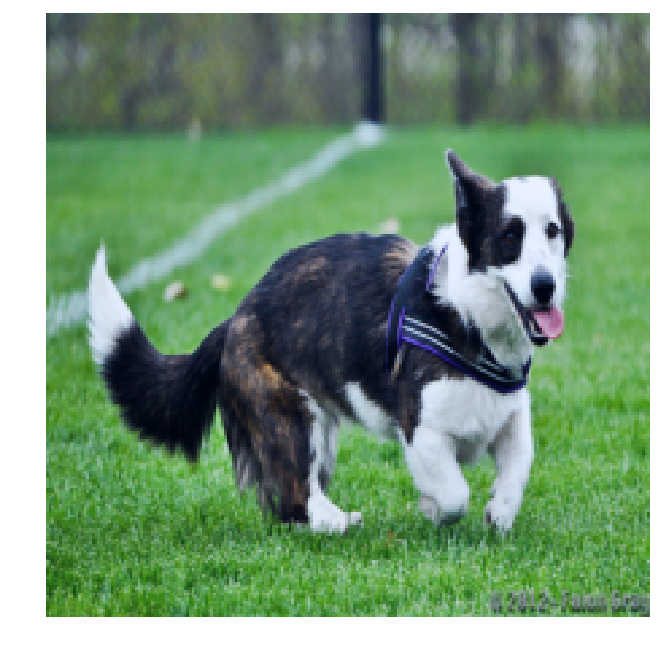

test


In [3]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

img = images[0].data.numpy()
img = np.moveaxis(img, 0, -1)
print(img.shape)
imshow_noax(img)
plt.show()
print('test')

Next, we load some pretrained ImageNet models. For now we're going to see if we can just get the visualization for AlexNet working.

In [4]:
# alexnet = models.alexnet(pretrained=True)
#densenet = models.densenet161(pretrained=True)
# resnet = models.resnet18(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
# vgg = models.vgg16(pretrained=True)

net = squeezenet

Now we need to run the 100 images through the network and store the outputs of the layers we want.

In [5]:
def numParams(module):
    total = 0
    for param in module.parameters():
        count = 1
        for elem in param.data.size():
            count *= elem
        total += count
    return total

def containsKeywords(name, keywords=('bn', 'relu', 'pool', 'downsample')):
    for word in keywords:
        if word in name:
            return True
    return False

modNames = []
modList = []
for name, module in net.named_modules():
    if numParams(module) < 1e6:
        if '.' in name:
            name = name.replace('.', '')
        modNames.append(name)
        modList.append(module)

print('Modules: ' + str(modNames))
            
layer_outputs = []

def c(self, input, output):
    layer_outputs.append(output)
    
for module in modList:
    module.register_forward_hook(c)

Modules: ['features', 'features0', 'features1', 'features2', 'features3', 'features3squeeze', 'features3squeeze_activation', 'features3expand1x1', 'features3expand1x1_activation', 'features3expand3x3', 'features3expand3x3_activation', 'features4', 'features4squeeze', 'features4squeeze_activation', 'features4expand1x1', 'features4expand1x1_activation', 'features4expand3x3', 'features4expand3x3_activation', 'features5', 'features5squeeze', 'features5squeeze_activation', 'features5expand1x1', 'features5expand1x1_activation', 'features5expand3x3', 'features5expand3x3_activation', 'features6', 'features7', 'features7squeeze', 'features7squeeze_activation', 'features7expand1x1', 'features7expand1x1_activation', 'features7expand3x3', 'features7expand3x3_activation', 'features8', 'features8squeeze', 'features8squeeze_activation', 'features8expand1x1', 'features8expand1x1_activation', 'features8expand3x3', 'features8expand3x3_activation', 'features9', 'features9squeeze', 'features9squeeze_activ

We can now run the forward pass through all of the images and all of the networks

In [6]:
# chunk_size = 10
# image_chunks = int(len(images) / chunk_size)
# for net in nets:
#     for i in range(image_chunks):
#         print('Chunk ' + str(i))
#         net.forward(images[chunk_size*i:chunk_size*(i+1)])

net.forward(images)

# layer_chunks = int(len(layer_outputs) / chunk_size)
# shortened_layer_outputs = []
# for i in range(layer_chunks):
#     shortened_layer_outputs.append(torch.cat(layer_outputs[i::layer_chunks]))
# layer_outputs = shortened_layer_outputs

Variable containing:
 11.4210   7.7211  14.2704  ...    7.0240  14.9230  18.8165
  8.7718   9.5606  14.4851  ...    4.7702   7.0184  10.0359
  2.9869   5.9080   3.4542  ...    0.8816   2.8515   6.1356
           ...               ⋱              ...            
  6.5845   9.1818   9.5328  ...    5.0051   8.2310  11.1193
 11.6489  14.5321  10.8729  ...   16.0833   6.2553  10.6034
  8.6625   8.3644   8.6811  ...   10.6968  14.0953   9.6184
[torch.FloatTensor of size 100x1000]

In [7]:
for i in range(len(layer_outputs)):
    print('Saving: ' + str(modNames[i] + '...'))
    np.save('activation_data/squeezenet/' + modNames[i], layer_outputs[i].data.numpy())

Saving: features...
Saving: features0...
Saving: features1...
Saving: features2...
Saving: features3...
Saving: features3squeeze...
Saving: features3squeeze_activation...
Saving: features3expand1x1...
Saving: features3expand1x1_activation...
Saving: features3expand3x3...
Saving: features3expand3x3_activation...
Saving: features4...
Saving: features4squeeze...
Saving: features4squeeze_activation...
Saving: features4expand1x1...
Saving: features4expand1x1_activation...
Saving: features4expand3x3...
Saving: features4expand3x3_activation...
Saving: features5...
Saving: features5squeeze...
Saving: features5squeeze_activation...
Saving: features5expand1x1...
Saving: features5expand1x1_activation...
Saving: features5expand3x3...
Saving: features5expand3x3_activation...
Saving: features6...
Saving: features7...
Saving: features7squeeze...
Saving: features7squeeze_activation...
Saving: features7expand1x1...
Saving: features7expand1x1_activation...
Saving: features7expand3x3...
Saving: features7